In [59]:
import os 
import getpass

def setup_environment():
    """Setup your API KEYs"""
    if not os.environ.get("OPENAI_API_KEY"):
        openai_key = getpass.getpass("Enter your OPENAI API KEY")
        os.environ["OPENAI_API_KEY"] = openai_key
    if not os.environ.get("SERPER_API_KEY"):
        serper_key = getpass.getpass("Enter your SERPER API KEY")
        os.environ["SERPER_API_KEY"] = serper_key
    if not os.environ.get("TAVILY_API_KEY"):
        tavily_key = getpass.getpass("Enter your TAVILY API KEY")
        os.environ["TAVILY_API_KEY"] = tavily_key   

    if not os.environ.get("LANGSMITH_API_KEY"):
        langsmith_key = getpass.getpass("ENTER your LAngsmith API KEY")
        if langsmith_key:
            os.environ["LANGSMITH_API_KEY"] = langsmith_key
            os.environ["LANGCHAIN_TRACING_V2"] ="true"
            os.environ["LANGCHAIN_PROJECT"] = "Langgraph tutorial"
        else:
            print("skipping langsmith set up")


    print("Envioenment setup completed")

In [60]:
setup_environment()

Envioenment setup completed


"""
Multi-Tool Research Assistant

A LangGraph-based agent that can:
1. Search the web for information using SerpAPI
2. Summarize articles and web content
3. Save research findings to files
4. Generate comprehensive research reports
"""

        User Query
        ↓
        [SerpAPI] ←─────────────── Search web
        ↓
        [List of URLs]
        ↓
        [Article Scraper] ←────── Extract content
        ↓
        [LLM Summarizer] ←────── Summarize text
        ↓
        [Save Raw + Summary]
        ↓
        [Generate Final Report]

Reasoner Model
generating research query--summarizing--reflecting on the research


In [61]:
from langgraph.graph import StateGraph , START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
# from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict, Annotated
import operator
from langchain_tavily import TavilySearch
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver

In [62]:
def get_llm():
    return ChatOpenAI(
        model = "gpt-4o",
        temperature= 0.0
    )

In [63]:
llm = get_llm()

In [64]:
llm.invoke('how are you?').content

"I'm just a computer program, so I don't have feelings, but I'm here to help you! How can I assist you today?"

In [28]:
# from pydantic import BaseModel, Field



In [65]:
def extract_result_from_tags(tag: str, result: str):
    if "</think>" in result:
        result = result.split("</think>")[1]
    #Extract using tags

    if f"<{tag}>" in result:
        return result.split(f"<{tag}>")[1].split(f"</{tag}>")[0]

    return result

In [66]:
def get_sources_from_search_results(search_results):
    """Extract source URLs from Tavily search results"""
    sources = []
    try:
        # Tavily returns a list of dictionaries with 'url' keys
        if isinstance(search_results, list):
            for result in search_results:
                if isinstance(result, dict) and 'url' in result:
                    sources.append(result['url'])
        # Sometimes it might return a dict with a list under a key like 'results'
        elif isinstance(search_results, dict):
            if 'results' in search_results and isinstance(search_results['results'], list):
                for result in search_results['results']:
                    if isinstance(result, dict) and 'url' in result:
                        sources.append(result['url'])
    except Exception as e:
        print(f"Error extracting sources: {e}")
    
    return sources

In [67]:
class InputState(TypedDict):
    topic: str
    max_web_searchs: int

In [68]:
class OutputState(TypedDict):
    summary: str

In [69]:
class ResearchState(InputState, OutputState):
    search_query: str
    research_loop_count: int
    sources_gathered: Annotated[list, operator.add]
    web_search_results: Annotated[list, operator.add]

In [70]:
def generate_first_query(state: InputState):
    prompt = (
        f"Your goal is to generate a targeted web search query. ... The topic is: {state['topic']} ..."
        "Please return the query wrapped in <query> tags. For example: <query>Suggested query</query>"
    )

    reasoner_llm = get_llm()  
    response = reasoner_llm.invoke(prompt)
  
    #Extract using tags
    query = extract_result_from_tags("query", response.content) 
    return {"search_query": query}

In [71]:
def web_search_generator(state: ResearchState):
    # Initialize TavilySearch first, then call it with the query
    search_tool = TavilySearch()
    search_results = search_tool.invoke(state['search_query'])

    return {
        "sources_gathered": [get_sources_from_search_results(search_results)],
        "web_search_results": [search_results],
        "research_loop_count": state["research_loop_count"] + 1 if "research_loop_count" in state else 1
    }



In [72]:
def summarize_sources(state: ResearchState):
    existing_summary = state.get("summary", "")
    last_web_search = state["web_search_results"][-1]
    prompt = (
        f"Generate a high-quality summary of the web search results ... The topic is: {state['topic']} ..."
        f"{f'Existing summary: {existing_summary}' if existing_summary else ''}"
        f"Search results: {last_web_search}"
        "Please return the summary wrapped in <summary> tags. For example: <summary>Suggested summary</summary>"
    )

    reasoner_llm = get_llm()
    # Use the invoke method with a properly formatted HumanMessage
    response = reasoner_llm.invoke([HumanMessage(content=prompt)])

    #Extract using tags
    summary = extract_result_from_tags("summary", response.content) 
    return {"summary": summary}

In [73]:
def reflect_on_suumary(state: ResearchState):
    prompt = (
        f"Identify knowledge gaps or areas that need deeper exploration ... The topic is: {state['topic']} ..."
        f"The summary is: {state['summary']}"
        "Please return the query wrapped in <query> tags. For example: <query>Suggested query</query>"
    )

    reasoner_llm = get_llm()
    # Use the invoke method with a properly formatted HumanMessage
    response = reasoner_llm.invoke([HumanMessage(content=prompt)])

    #Extract using tags
    query = extract_result_from_tags("query", response.content)    
    return {"search_query": query}

In [76]:
def finalize_summary(state: ResearchState):
  # Flatten the list of lists and ensure they're all strings
  all_sources_flat = []
  for source_list in state["sources_gathered"]:
    if isinstance(source_list, list):
      all_sources_flat.extend(source_list)
    else:
      all_sources_flat.append(source_list)
      
  # Remove duplicates while preserving order
  unique_sources = []
  for source in all_sources_flat:
    if source not in unique_sources and isinstance(source, str):
      unique_sources.append(source)
      
  all_sources = "\n".join(source for source in unique_sources)
  final_summary = f"## Summary\n\n{state['summary']}\n\n ### Sources:\n{all_sources}"
    
  return {"summary": final_summary}

In [77]:
def reasearch_router(state: ResearchState) -> Literal["finalize_summary", "web_research"]:
    if state["research_loop_count"] < state["max_web_searchs"]:
        return "web_research"
    else:
        return "finalize_summary"

In [ ]:
def get_workflow():
    # Use input_schema and output_schema instead of the deprecated input and output parameters
    builder = StateGraph(ResearchState, input_schema=InputState, output_schema=OutputState)

    # Add nodes
    builder.add_node("generate_first_query", generate_first_query)
    builder.add_node("web_research", web_search_generator)
    builder.add_node("summarize_sources", summarize_sources)
    builder.add_node("reflect_on_summary", reflect_on_suumary)
    builder.add_node("finalize_summary", finalize_summary)

    # Add edges
    builder.add_edge(START, "generate_first_query")
    builder.add_edge("generate_first_query", "web_research")
    builder.add_edge("web_research", "summarize_sources")
    builder.add_edge("summarize_sources", "reflect_on_summary")
    builder.add_conditional_edges("reflect_on_summary", reasearch_router)
    builder.add_edge("finalize_summary", END)

    return builder.compile()



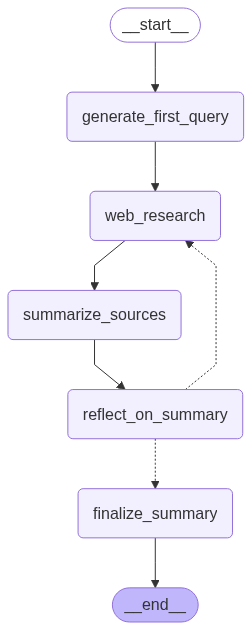

In [88]:
graph_workflow  = get_workflow()
from IPython.display import Image, display

display(Image(graph_workflow.get_graph().draw_mermaid_png()))



In [80]:
workflow = get_workflow()

result = workflow.invoke({
    "topic": "How was deepseek r1 trained",
    "max_web_searchs": 3
})
print("\n\nRESEARCH SUMMARY:\n=================\n")
print(result["summary"]) #Display the summary



RESEARCH SUMMARY:

## Summary

DeepSeek-R1 was trained using a multi-stage process that combines Supervised Fine-Tuning (SFT) and Reinforcement Learning (RL) across two stages each. The training methodology emphasizes complex reasoning tasks such as mathematics, coding, and scientific reasoning. A key component of the training is the use of Group Relative Policy Optimization (GRPO), which is applied with rule-based and outcome reward models to enhance the model's helpfulness and harmlessness. This approach allows DeepSeek-R1 to rival OpenAI's models in reasoning tasks without relying on labeled data, utilizing pure RL techniques. Specific datasets or sources of data used during the SFT and RL stages were not detailed in the search results, but the Medical Chain-of-Thought Dataset from Hugging Face was mentioned as part of the fine-tuning process.

 ### Sources:
https://www.linkedin.com/pulse/deepseek-r1-training-process-qi-he-hnn9e
https://www.philschmid.de/deepseek-r1
https://medium

In [86]:
from pprint import pprint
pprint(result['summary'])

('## Summary\n'
 '\n'
 'DeepSeek-R1 was trained using a multi-stage process that combines Supervised '
 'Fine-Tuning (SFT) and Reinforcement Learning (RL) across two stages each. '
 'The training methodology emphasizes complex reasoning tasks such as '
 'mathematics, coding, and scientific reasoning. A key component of the '
 'training is the use of Group Relative Policy Optimization (GRPO), which is '
 "applied with rule-based and outcome reward models to enhance the model's "
 'helpfulness and harmlessness. This approach allows DeepSeek-R1 to rival '
 "OpenAI's models in reasoning tasks without relying on labeled data, "
 'utilizing pure RL techniques. Specific datasets or sources of data used '
 'during the SFT and RL stages were not detailed in the search results, but '
 'the Medical Chain-of-Thought Dataset from Hugging Face was mentioned as part '
 'of the fine-tuning process.\n'
 '\n'
 ' ### Sources:\n'
 'https://www.linkedin.com/pulse/deepseek-r1-training-process-qi-he-hnn9e\n'